<a href="https://colab.research.google.com/github/clive-limo/DataScienceProjects/blob/main/Spark_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Spark Assignment

**Preparing the work environment**



In [ ]:

# [1] download and install pyspark in Google Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark



In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

spark = SparkSession.builder\
        .master("local")\
        .appName("Spark Assignment")\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()
spark

from pyspark.sql import SQLContext

spcont = SparkContext.getOrCreate();
sqlContext = SQLContext(spcont)




In [ ]:
# Importing data

logs_df = sqlContext.read.csv("/content/*.csv",inferSchema=True, header =True)
logs_RDD = spark.sparkContext.textFile("/content/*.csv")
logs_df.show()

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+--------------

**Data Pre-processing**

The data pre processing involves dealing with the null values present in the dataset. in this case, the null values will be ommited from the dataset.

In [ ]:
# Structure of the dataframe

logs_df.printSchema()
logs_df.count()

# Removing null values

logs_df.dropna()
logs_df.count()

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: long (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: integer (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: long (nullable = true)
 |-- Flow IAT Min: long (nullable = true)
 |

1048575

**Spark SQL Queries**

+--------------+------+
|         label| count|
+--------------+------+
|SSH-Bruteforce|187589|
|        Benign|667626|
|FTP-BruteForce|193360|
+--------------+------+



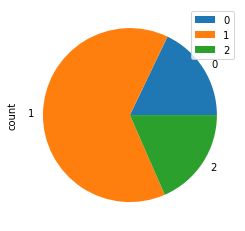

In [ ]:
# SQL queries

## Query 1

import matplotlib.pyplot as plt
import pandas as pd


labels_df = logs_df.groupBy("label").count().show()
labels_df = logs_df.groupBy("label").count().toPandas()
labels_df.plot(x='label', y='count', kind='pie')




In [ ]:
## Query 2
logs_df.filter((logs_df["Label"]=="SSH-Bruteforce")&
              (logs_df["Flow Duration"] > 500000)).show()


+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-------------

**Data Analysis**

In [ ]:
# Data Analysis
from pyspark.mllib.stat import KernelDensity

## Descriptive statistics
logs_df.describe(["Label"]).show()

+-------+--------------+
|summary|         Label|
+-------+--------------+
|  count|       1048575|
|   mean|          null|
| stddev|          null|
|    min|        Benign|
|    max|SSH-Bruteforce|
+-------+--------------+



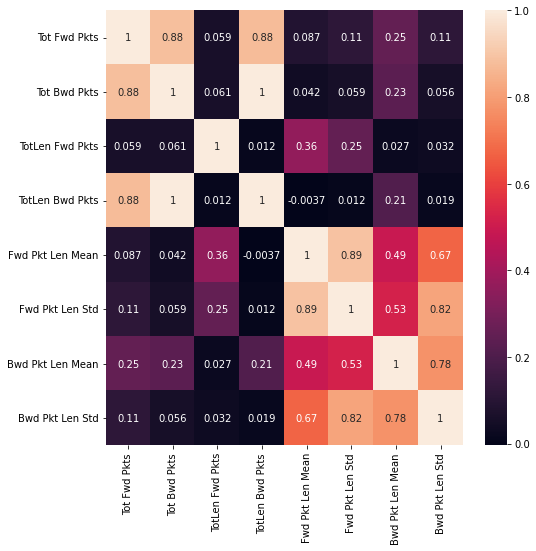

In [ ]:
# Correlation
corr_features=[
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',]

import seaborn as sb
import matplotlib.pyplot as plt

pandas_df = logs_df.toPandas()
plt.figure(figsize=(8,8))
mtx_df=pandas_df[corr_features].corr()
sb.heatmap(mtx_df,annot=True)
plt.show()

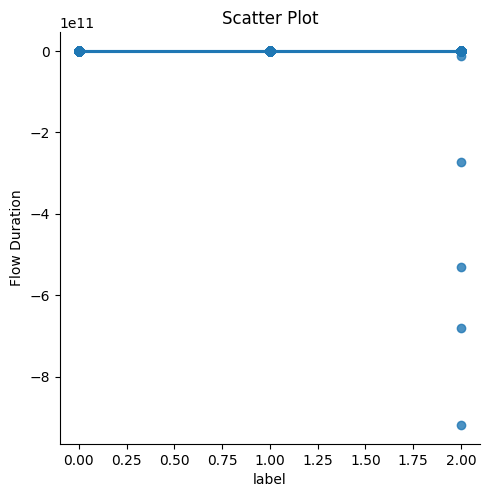

In [ ]:
# Scatter Plot
import seaborn as sns
from pyspark.sql.types import IntegerType

# Preparing data for linear regression
logs_df = logs_df.na.replace("SSH-Bruteforce", "0")
logs_df = logs_df.na.replace("FTP-BruteForce", "1")
logs_df = logs_df.na.replace("Benign", "2")

logs_df = logs_df.withColumn("label", logs_df["label"].cast(IntegerType()))

plot_df = logs_df.select('label','Flow Duration').toPandas()

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='label', y='Flow Duration', data=plot_df)
plt.title("Scatter Plot");

In [ ]:
# Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

# Preparing data for linear regression
logs_df = logs_df.na.replace("SSH-Bruteforce", "0")
logs_df = logs_df.na.replace("FTP-BruteForce", "1")
logs_df = logs_df.na.replace("Benign", "2")

logs_df = logs_df.withColumn("label", logs_df["label"].cast(IntegerType()))

# Creating a regression df with features and label columns
vectorAssembler = VectorAssembler(inputCols = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std'], outputCol = 'features')
vlog_df = vectorAssembler.transform(logs_df)
vlog_df = vlog_df.select(['features', 'label'])
vlog_df.show(3)

# Spliting df into testing and training
df_split = vlog_df.randomSplit([0.75, 0.25])
train_df = df_split[0]
test_df = df_split[1]

# Fitting linear regression model
reg = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
reg_model = reg.fit(train_df)
print("Coefficients: " + str(reg_model.coefficients))
print("Intercept: " + str(reg_model.intercept))

# Making predictions using model
from pyspark.ml.evaluation import RegressionEvaluator

model_pred = reg_model.transform(test_df)
model_pred.select("Prediction","label","features").show(10)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(9,[0,1],[1.12641...|    2|
|(9,[0,1],[1.12641...|    2|
|(9,[0,1],[1.12638...|    2|
+--------------------+-----+
only showing top 3 rows

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 1.457922485509587
+-----------------+-----+--------------------+
|       Prediction|label|            features|
+-----------------+-----+--------------------+
|1.457922485509587|    2|(9,[0,1],[-9.1901...|
|1.457922485509587|    2|(9,[0,1],[-2.7385...|
|1.457922485509587|    2|(9,[0,1],[-1.1873...|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
|1.457922485509587|    2| (9,[0,1],[1.0,2.0])|
+-----------------+-----+--------------------+
only showing top 10 rows



In [ ]:
%%shell
jupyter nbconvert --to html /content/sparkProjectFinal.ipynb


[NbConvertApp] Converting notebook /content/sparkProjectFinal.ipynb to html
[NbConvertApp] Writing 423404 bytes to /content/sparkProjectFinal.html
